# Alphabet Soup's Charity Risk Assessment

Alphabet Soup is a fictional nonprofit foundation that makes donations to various organizations that aim to make the world a better place by protecting the environment, improving people's well-being, etc. Unfortunately, not every investment by the foundation is impactful. The goal of this project is to come up with a data-driven solution to help ensure that the foundation's money is going to organizations that are worth donating to. The solution is to build a model to assess an organization's risk before donating to them.

### Dependencies and data

In [1]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras

/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tribui/miniconda3/envs/minds/lib/pyt

In [2]:
# Data
df = pd.read_csv('data/charity_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [3]:
df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### EDA

In [4]:
# Unique value counts
df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [5]:
# Inspect integer columns
df.describe()

,EIN,STATUS,ASK_AMT,IS_SUCCESSFUL
count,3.429900e+04,34299.000000,3.429900e+04,34299.000000
mean,5.191852e+08,0.999854,2.769199e+06,0.532406
std,2.451472e+08,0.012073,8.713045e+07,0.498956
min,1.052060e+07,0.000000,5.000000e+03,0.000000
25%,2.748482e+08,1.000000,5.000000e+03,0.000000
50%,4.656317e+08,1.000000,5.000000e+03,1.000000
75%,7.526117e+08,1.000000,7.742000e+03,1.000000
max,9.960869e+08,1.000000,8.597806e+09,1.000000


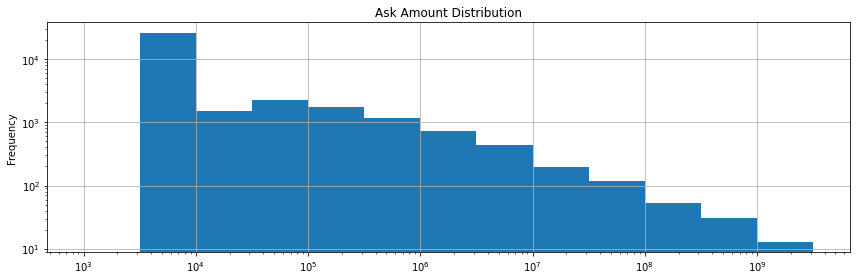

In [43]:
# Inspect `ASK_AMT`
ask = df['ASK_AMT']
ask.plot(kind='hist', bins=10**np.arange(3, 10, 0.5), grid=True, figsize=(12, 4), title='Ask Amount Distribution')
plt.yscale('log')
plt.xscale('log')
plt.show()